#**GRU model training and testing**



###Drive preparation section

Mounting google drive to access data on drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Assigning variables to file path

In [2]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab_Notebooks/Dissertation' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Data', 'Code']


In [3]:
DATA_PATH_AFTER_MYDRIVE = 'Colab_Notebooks/Dissertation/Data' 
DATA_PATH = os.path.join('drive', 'My Drive', DATA_PATH_AFTER_MYDRIVE)
print(os.listdir(DATA_PATH))

['Bengaluru_air_met_df.csv', 'Delhi_air_met_df.csv', 'Hyderabad_air_met_df.csv', 'Jaipur_air_met_df.csv', 'Mumbai_air_met_df.csv', 'Saved_Models']


###Packages installation section

Installation of tensorflow package for algorithms.

In [4]:
! pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Installation of PerMetrics package for Performance metrics of models

In [5]:
! pip install permetrics==1.2.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Installation of Keras Tuner package for hyperparameter tuning of models.

In [6]:
! pip install keras-tuner -q

     |████████████████████████████████| 135 kB 6.8 MB/s 
     |████████████████████████████████| 1.6 MB 55.5 MB/s 


Installation of tensorflow addons package for AdamW optimizer.

In [7]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 8.8 MB/s 


###Time series data preparation section

Import of necessary libraries.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras import layers
from math import sqrt
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from permetrics.regression import RegressionMetric
import keras_tuner
import tensorflow_addons as tfa
import time
import pickle

Seed random generators for consistent results over different runs of the code script.

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

Load data preprocessed data set of air pollution and meteorological data for Delhi city into a pandas dataframe.

In [10]:
Delhi_air_met_df = pd.read_csv(os.path.join(DATA_PATH,'Delhi_air_met_df.csv'))

Delete unnecessary columns.

In [11]:
Delhi_air_met_df.drop(columns=['Unnamed: 0', 'Datetime'], inplace=True)

*Coding reference for above executions:*

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

Splitting data into train and test sets without shuffeling, to preserve the chronology of the time series data.

In [12]:
train_size = int(len(Delhi_air_met_df) * 0.8)
test_size = len(Delhi_air_met_df) - train_size
train_df, test_df = Delhi_air_met_df.iloc[0:train_size], Delhi_air_met_df.iloc[train_size:len(Delhi_air_met_df)]

*Coding reference for above executions:*

https://curiousily.com/posts/demand-prediction-with-lstms-using-tensorflow-2-and-keras-in-python/

https://www.youtube.com/watch?v=xaIA83x5Icg

Creation of normalization object.

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))

Fitting only training data to normalization object.

In [14]:
train_df = pd.DataFrame(scaler.fit_transform(train_df), columns=train_df.columns)

Scaling test data with normalization object that has been trained with training data only.

In [15]:
test_df = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)

Defining a function to create Rolling Window of time series data.

In [13]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

Assigning variable to time period/frame of past timestamps, which the models would take as input to predict target value at future timestamp(S).

In [17]:
time_steps = 24

Obtraining variables and targets for training and test data sets in Rolling Window format unsing above defined function. 

Note that the variables that will be input for the algorithms will be in 3 dimensional array, with a shape as 

(no. of observations, time steps of past, number of variable).

In [18]:
X_train, y_train = create_dataset(train_df, train_df['PM2.5'], time_steps)
X_test, y_test = create_dataset(test_df, test_df['PM2.5'], time_steps)

*Coding reference for above executions:*

https://curiousily.com/posts/demand-prediction-with-lstms-using-tensorflow-2-and-keras-in-python/

https://www.youtube.com/watch?v=xaIA83x5Icg

###Model trainig, testing and tuning section

Creation of early stopping object to stop trainig after no decrease in loss function value after consecutive number of steps assigned to patience argument.

In [11]:
early_stopping_monitor = EarlyStopping(patience=10)

*Coding reference for above executions:*

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

Creation of baseline model.

In [20]:
GRU_model0 = keras.Sequential()
GRU_model0.add(layers.GRU(64, input_shape=(X_train.shape[1], X_train.shape[2])))
GRU_model0.add(layers.Dense(1))
GRU_model0.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.01))

*Coding reference for above executions:*

https://keras.io/api/layers/recurrent_layers/lstm/

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

Fitting baseline model to training data.

In [21]:
GRU0_history = GRU_model0.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 13s 22ms/step - loss: 0.0436 - val_loss: 0.0125
Epoch 2/100
479/479 [==============================] - 8s 16ms/step - loss: 0.0320 - val_loss: 0.0161
Epoch 3/100
479/479 [==============================] - 8s 16ms/step - loss: 0.0314 - val_loss: 0.0125
Epoch 4/100
479/479 [==============================] - 7s 15ms/step - loss: 0.0312 - val_loss: 0.0157
Epoch 5/100
479/479 [==============================] - 8s 17ms/step - loss: 0.0310 - val_loss: 0.0115
Epoch 6/100
479/479 [==============================] - 7s 15ms/step - loss: 0.0310 - val_loss: 0.0119
Epoch 7/100
479/479 [==============================] - 7s 16ms/step - loss: 0.0305 - val_loss: 0.0128
Epoch 8/100
479/479 [==============================] - 8s 16ms/step - loss: 0.0304 - val_loss: 0.0115
Epoch 9/100
479/479 [==============================] - 9s 19ms/step - loss: 0.0306 - val_loss: 0.0140
Epoch 10/100
479/479 [==============================] - 8s 17ms/step - loss: 0.03

Plotting loss curves of trainig and validation sets during the training of the baseline model.

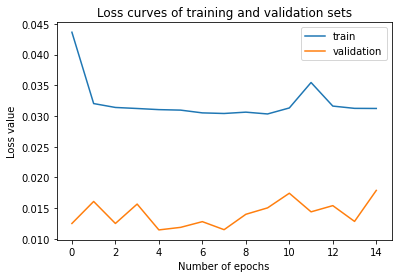

In [22]:
plt.plot(GRU0_history.history['loss'], label='train')
plt.plot(GRU0_history.history['val_loss'], label='validation')
plt.legend()
plt.title('Loss curves of training and validation sets')
plt.xlabel('Number of epochs')
plt.ylabel('Loss value')
plt.show()

Prediction of target values for test data set variables.

In [23]:
y_pred0 = GRU_model0.predict(X_test)

Reshaping the array of actual target values of test data set and then applying inverse transformation to get them to original scale before comparison with prediction values.

In [21]:
y_test_reshaped = y_test.reshape(-1,1)
y_test_inv = np.concatenate((test_df.values[:-24,:-1], y_test_reshaped), axis=1)
y_test_inv = scaler.inverse_transform(y_test_inv)[:,-1]

Defining a function that would apply inverse transform to the predicted values of target for test data set to make them comparable with the actual values of target in the original scale of the data.

In [12]:
def prediction_invertor(ypredict):
  ypredict_inverse = np.concatenate((test_df.values[:-24,:-1], ypredict), axis=1)
  ypredict_inverse = scaler.inverse_transform(ypredict_inverse)[:,-1]

  return ypredict_inverse;

Obtaining predicted value of test target column in scale of original data.

In [26]:
y_pred0_inv = prediction_invertor(y_pred0)

Evaluation of baseline model performance in terms of Root Mean Square Error by comparing the actual and predicted values of target column of test data set.

In [27]:
rmse0 = metrics.mean_squared_error(y_test_inv, y_pred0_inv, squared=False)
print('Test RMSE: %.3f' % rmse0)

Test RMSE: 23.880


*Coding reference for above executions:*

https://keras.io/api/layers/recurrent_layers/lstm/

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

Creation of small subsets of training data to fit to models for hyperparameter tuning.

In [20]:
X_grid, y_grid = X_train[:10000], y_train[:10000]

Creation of small subsets of training data to validate models for hyperparameter tuning.

In [21]:
X_grid_val, y_grid_val = X_train[10000:12000], y_train[10000:12000]

Defining a function to be used in keras tuners for hyperparameter tuning to determine optimal values of neurons and optimizer learning rate.

In [22]:
from sklearn import metrics
def build_model1(hp):
  model = keras.Sequential()
  model.add(layers.GRU(units=hp.Int("units", min_value=50, max_value=200, step=50), input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(layers.Dense(1))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=['accuracy'])
  
  return model

*Coding reference for above executions:*

https://www.youtube.com/watch?v=Lx16T9cl5ng

https://neptune.ai/blog/keras-tuner-tuning-hyperparameters-deep-learning-model

https://medium.com/swlh/hyperparameter-tuning-in-keras-tensorflow-2-with-keras-tuner-randomsearch-hyperband-3e212647778f

https://keras.io/guides/keras_tuner/getting_started/

https://keras.io/api/keras_tuner/tuners/base_tuner/

Creation of Hyperband tuner object for hyperparameter tuning.

In [23]:
tuner11 = keras_tuner.Hyperband(
    hypermodel=build_model1,
    objective="val_accuracy",
    max_epochs=50,
    factor=2,
    )

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [24]:
tuner11.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 12 Complete [00h 00m 06s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 01m 29s


Best hyperparameters obtained using Hyperband tuner.

In [25]:
tuner11.get_best_hyperparameters()[0].values

{'units': 150,
 'learning_rate': 0.01,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 5,
 'tuner/round': 0}

Creation of Bayesian Optimization tuner object for hyperparameter tuning.

In [26]:
tuner12 = keras_tuner.BayesianOptimization(
    hypermodel=build_model1,
    objective='val_accuracy',
    max_trials=10,
    num_initial_points=2,
    alpha=0.0001,
    beta=2.6,
    directory="my_dir",
    project_name="BLR_BiLSTM",
)

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [27]:
tuner12.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 10 Complete [00h 01m 07s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 09m 24s


Best hyperparameters obtained using Bayesian Optimization tuner.

In [28]:
tuner12.get_best_hyperparameters()[0].values

{'units': 50, 'learning_rate': 0.01}

*Coding reference for above executions:*

https://www.youtube.com/watch?v=Lx16T9cl5ng

https://neptune.ai/blog/keras-tuner-tuning-hyperparameters-deep-learning-model

https://medium.com/swlh/hyperparameter-tuning-in-keras-tensorflow-2-with-keras-tuner-randomsearch-hyperband-3e212647778f

https://keras.io/guides/keras_tuner/getting_started/

https://keras.io/api/keras_tuner/tuners/base_tuner/

Creating, training and testing models with best hyperparameters obtained from Hyperband tuner.

In [22]:
GRU_model11 = keras.Sequential()
GRU_model11.add(layers.GRU(150, input_shape=(X_train.shape[1], X_train.shape[2])))
GRU_model11.add(layers.Dense(1))
GRU_model11.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.01))

In [23]:
GRU11_history = GRU_model11.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 24s 46ms/step - loss: 0.0456 - val_loss: 0.0147
Epoch 2/100
479/479 [==============================] - 23s 48ms/step - loss: 0.0322 - val_loss: 0.0176
Epoch 3/100
479/479 [==============================] - 21s 45ms/step - loss: 0.0314 - val_loss: 0.0117
Epoch 4/100
479/479 [==============================] - 23s 49ms/step - loss: 0.0314 - val_loss: 0.0156
Epoch 5/100
479/479 [==============================] - 24s 51ms/step - loss: 0.0311 - val_loss: 0.0143
Epoch 6/100
479/479 [==============================] - 21s 44ms/step - loss: 0.0309 - val_loss: 0.0139
Epoch 7/100
479/479 [==============================] - 22s 45ms/step - loss: 0.0306 - val_loss: 0.0125
Epoch 8/100
479/479 [==============================] - 22s 46ms/step - loss: 0.0305 - val_loss: 0.0131
Epoch 9/100
479/479 [==============================] - 21s 45ms/step - loss: 0.0306 - val_loss: 0.0119
Epoch 10/100
479/479 [==============================] - 24s 49ms/step - l

In [24]:
y_pred11 = GRU_model11.predict(X_test)

In [25]:
y_pred11_inv = prediction_invertor(y_pred11)

In [26]:
rmse11 = metrics.mean_squared_error(y_test_inv, y_pred11_inv, squared=False)
print('Test RMSE: %.3f' % rmse11)

Test RMSE: 23.088


Creating, training and testing models with best hyperparameters obtained from Bayesian Optimization tuner.

In [27]:
GRU_model12 = keras.Sequential()
GRU_model12.add(layers.GRU(50, input_shape=(X_train.shape[1], X_train.shape[2])))
GRU_model12.add(layers.Dense(1))
GRU_model12.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.01))

In [28]:
GRU12_history = GRU_model12.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/50
479/479 [==============================] - 10s 17ms/step - loss: 0.0411 - val_loss: 0.0174
Epoch 2/50
479/479 [==============================] - 8s 16ms/step - loss: 0.0319 - val_loss: 0.0134
Epoch 3/50
479/479 [==============================] - 8s 16ms/step - loss: 0.0313 - val_loss: 0.0120
Epoch 4/50
479/479 [==============================] - 8s 17ms/step - loss: 0.0310 - val_loss: 0.0140
Epoch 5/50
479/479 [==============================] - 8s 17ms/step - loss: 0.0310 - val_loss: 0.0144
Epoch 6/50
479/479 [==============================] - 8s 16ms/step - loss: 0.0308 - val_loss: 0.0127
Epoch 7/50
479/479 [==============================] - 8s 16ms/step - loss: 0.0307 - val_loss: 0.0153
Epoch 8/50
479/479 [==============================] - 8s 17ms/step - loss: 0.0305 - val_loss: 0.0118
Epoch 9/50
479/479 [==============================] - 8s 16ms/step - loss: 0.0305 - val_loss: 0.0142
Epoch 10/50
479/479 [==============================] - 8s 17ms/step - loss: 0.0304 - val_l

In [29]:
y_pred12 = GRU_model12.predict(X_test)

In [30]:
y_pred12_inv = prediction_invertor(y_pred12)

In [31]:
rmse12 = metrics.mean_squared_error(y_test_inv, y_pred12_inv, squared=False)
print('Test RMSE: %.3f' % rmse12)

Test RMSE: 52.261


Defining a function to be used in keras tuners for hyperparameter tuning to determine optimal values of neurons and optimizer learning rate.

In [22]:
from sklearn import metrics
def build_model12(hp):
  model = keras.Sequential()
  model.add(layers.GRU(units=hp.Int("units", min_value=60, max_value=100, step=10), input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(layers.Dense(1))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=['accuracy'])
  
  return model

Creation of Hyperband tuner object for hyperparameter tuning.

In [23]:
tuner112 = keras_tuner.Hyperband(
    hypermodel=build_model12,
    objective="val_accuracy",
    max_epochs=50,
    factor=2,
    )

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [24]:
tuner112.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 15 Complete [00h 00m 14s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 05m 03s


Best hyperparameters obtained using Hyperband tuner.

In [25]:
tuner112.get_best_hyperparameters()[0].values

{'units': 80,
 'learning_rate': 0.01,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 5,
 'tuner/round': 0}

Creation of Bayesian Optimization tuner object for hyperparameter tuning.

In [26]:
tuner122 = keras_tuner.BayesianOptimization(
    hypermodel=build_model12,
    objective='val_accuracy',
    max_trials=10,
    num_initial_points=2,
    alpha=0.0001,
    beta=2.6,
    directory="my_dir",
    project_name="BLR_BiLSTM",
)

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [27]:
tuner122.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 10 Complete [00h 03m 45s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 30m 58s


Best hyperparameters obtained using Bayesian Optimization tuner.

In [28]:
tuner122.get_best_hyperparameters()[0].values

{'units': 80, 'learning_rate': 0.0001}

Creating, training and testing models with best hyperparameters obtained from Hyperband tuner.

In [22]:
GRU_model13 = keras.Sequential()
GRU_model13.add(layers.GRU(80, input_shape=(X_train.shape[1], X_train.shape[2])))
GRU_model13.add(layers.Dense(1))
GRU_model13.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.01))

In [23]:
GRU13_history = GRU_model13.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 13s 22ms/step - loss: 0.0449 - val_loss: 0.0211
Epoch 2/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0322 - val_loss: 0.0186
Epoch 3/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0313 - val_loss: 0.0120
Epoch 4/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0310 - val_loss: 0.0133
Epoch 5/100
479/479 [==============================] - 11s 23ms/step - loss: 0.0313 - val_loss: 0.0117
Epoch 6/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0309 - val_loss: 0.0126
Epoch 7/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0306 - val_loss: 0.0114
Epoch 8/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0303 - val_loss: 0.0107
Epoch 9/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0307 - val_loss: 0.0124
Epoch 10/100
479/479 [==============================] - 12s 25ms/step - l

In [24]:
y_pred13 = GRU_model13.predict(X_test)

In [25]:
y_pred13_inv = prediction_invertor(y_pred13)

In [26]:
rmse13 = metrics.mean_squared_error(y_test_inv, y_pred13_inv, squared=False)
print('Test RMSE: %.3f' % rmse13)

Test RMSE: 20.096


Creating, training and testing models with best hyperparameters obtained from Bayesian Optimization tuner.

In [27]:
GRU_model14 = keras.Sequential()
GRU_model14.add(layers.GRU(80, input_shape=(X_train.shape[1], X_train.shape[2])))
GRU_model14.add(layers.Dense(1))
GRU_model14.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.0001))

In [28]:
GRU14_history = GRU_model14.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 13s 22ms/step - loss: 0.0510 - val_loss: 0.0260
Epoch 2/100
479/479 [==============================] - 12s 25ms/step - loss: 0.0354 - val_loss: 0.0200
Epoch 3/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0335 - val_loss: 0.0161
Epoch 4/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0325 - val_loss: 0.0163
Epoch 5/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0320 - val_loss: 0.0136
Epoch 6/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0318 - val_loss: 0.0133
Epoch 7/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0317 - val_loss: 0.0127
Epoch 8/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0316 - val_loss: 0.0124
Epoch 9/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0315 - val_loss: 0.0154
Epoch 10/100
479/479 [==============================] - 10s 21ms/step - l

In [29]:
y_pred14 = GRU_model14.predict(X_test)

In [30]:
y_pred14_inv = prediction_invertor(y_pred14)

In [31]:
rmse14 = metrics.mean_squared_error(y_test_inv, y_pred14_inv, squared=False)
print('Test RMSE: %.3f' % rmse14)

Test RMSE: 23.651


Defining a function to be used in keras tuners for hyperparameter tuning to determine optimal values of neurons and optimizer learning rate.

In [22]:
from sklearn import metrics
def build_model13(hp):
  model = keras.Sequential()
  model.add(layers.GRU(units=hp.Int("units", min_value=70, max_value=90, step=5), input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(layers.Dense(1))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])
  model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=['accuracy'])
  
  return model

Creation of Hyperband tuner object for hyperparameter tuning.

In [23]:
tuner113 = keras_tuner.Hyperband(
    hypermodel=build_model13,
    objective="val_accuracy",
    max_epochs=50,
    factor=2,
    )

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [24]:
tuner113.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 10 Complete [00h 00m 07s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 01m 08s


Best hyperparameters obtained using Hyperband tuner.

In [25]:
tuner113.get_best_hyperparameters()[0].values

{'units': 85,
 'learning_rate': 0.01,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 5,
 'tuner/round': 0}

Creation of Bayesian Optimization tuner object for hyperparameter tuning.

In [26]:
tuner123 = keras_tuner.BayesianOptimization(
    hypermodel=build_model13,
    objective='val_accuracy',
    max_trials=10,
    num_initial_points=2,
    alpha=0.0001,
    beta=2.6,
    directory="my_dir",
    project_name="BLR_BiLSTM",
)

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [27]:
tuner123.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 10 Complete [00h 00m 42s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 07m 08s


Best hyperparameters obtained using Bayesian Optimization tuner.

In [28]:
tuner123.get_best_hyperparameters()[0].values

{'units': 80, 'learning_rate': 0.01}

Creating, training and testing models with best hyperparameters obtained from Hyperband tuner.

In [24]:
GRU_model15 = keras.Sequential()
GRU_model15.add(layers.GRU(85, input_shape=(X_train.shape[1], X_train.shape[2])))
GRU_model15.add(layers.Dense(1))
GRU_model15.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.01))

In [25]:
GRU15_history = GRU_model15.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 14s 24ms/step - loss: 0.0428 - val_loss: 0.0147
Epoch 2/100
479/479 [==============================] - 13s 27ms/step - loss: 0.0319 - val_loss: 0.0174
Epoch 3/100
479/479 [==============================] - 11s 23ms/step - loss: 0.0313 - val_loss: 0.0122
Epoch 4/100
479/479 [==============================] - 11s 23ms/step - loss: 0.0310 - val_loss: 0.0123
Epoch 5/100
479/479 [==============================] - 11s 23ms/step - loss: 0.0310 - val_loss: 0.0111
Epoch 6/100
479/479 [==============================] - 11s 23ms/step - loss: 0.0309 - val_loss: 0.0114
Epoch 7/100
479/479 [==============================] - 11s 23ms/step - loss: 0.0306 - val_loss: 0.0135
Epoch 8/100
479/479 [==============================] - 11s 23ms/step - loss: 0.0305 - val_loss: 0.0151
Epoch 9/100
479/479 [==============================] - 11s 23ms/step - loss: 0.0306 - val_loss: 0.0126
Epoch 10/100
479/479 [==============================] - 11s 23ms/step - l

In [26]:
y_pred15 = GRU_model15.predict(X_test)

In [27]:
y_pred15_inv = prediction_invertor(y_pred15)

In [28]:
rmse15 = metrics.mean_squared_error(y_test_inv, y_pred15_inv, squared=False)
print('Test RMSE: %.3f' % rmse15)

Test RMSE: 28.543


Creating, training and testing models with best hyperparameters obtained from Bayesian Optimization tuner.

In [29]:
GRU_model16 = keras.Sequential()
GRU_model16.add(layers.GRU(80, input_shape=(X_train.shape[1], X_train.shape[2])))
GRU_model16.add(layers.Dense(1))
GRU_model16.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.001))

In [30]:
GRU16_history = GRU_model16.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 13s 22ms/step - loss: 0.0389 - val_loss: 0.0173
Epoch 2/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0332 - val_loss: 0.0149
Epoch 3/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0327 - val_loss: 0.0129
Epoch 4/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0318 - val_loss: 0.0125
Epoch 5/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0316 - val_loss: 0.0118
Epoch 6/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0316 - val_loss: 0.0122
Epoch 7/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0312 - val_loss: 0.0112
Epoch 8/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0311 - val_loss: 0.0120
Epoch 9/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0312 - val_loss: 0.0125
Epoch 10/100
479/479 [==============================] - 10s 21ms/step - l

In [31]:
y_pred16 = GRU_model16.predict(X_test)

In [32]:
y_pred16_inv = prediction_invertor(y_pred16)

In [33]:
rmse16 = metrics.mean_squared_error(y_test_inv, y_pred16_inv, squared=False)
print('Test RMSE: %.3f' % rmse16)

Test RMSE: 21.506


Defining a function to be used in keras tuners for hyperparameter tuning to determine optimal values of neurons, hidden layers and optimizer learning rate.

In [22]:
from sklearn import metrics
def build_model2(hp):
  model = keras.Sequential()
  model.add(layers.GRU(units=hp.Int(f"input_units", min_value=50, max_value=80, step=10), return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))

  for i in range(hp.Int("num_layers", 1,3)):
    model.add(layers.GRU(units=hp.Int(f"units_{i}", min_value=50, max_value=80, step=10), return_sequences=True))
  
  model.add(layers.Dense(1))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=['accuracy'])
  
  return model

Creation of Hyperband tuner object for hyperparameter tuning.

In [23]:
tuner21 = keras_tuner.Hyperband(
    hypermodel=build_model2,
    objective="val_accuracy",
    max_epochs=50,
    factor=2,
    )

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [24]:
tuner21.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 186 Complete [00h 01m 27s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 01h 28m 22s


Best hyperparameters obtained using Hyperband tuner.

In [25]:
tuner21.get_best_hyperparameters()[0].values

{'input_units': 70,
 'num_layers': 1,
 'units_0': 70,
 'learning_rate': 0.001,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 5,
 'tuner/round': 0}

Creation of Bayesian Optimization tuner object for hyperparameter tuning.

In [26]:
tuner22 = keras_tuner.BayesianOptimization(
    hypermodel=build_model2,
    objective='val_accuracy',
    max_trials=10,
    num_initial_points=2,
    alpha=0.0001,
    beta=2.6,
    directory="my_dir",
    project_name="BLR_BiLSTM",
)

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [27]:
tuner22.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 10 Complete [00h 00m 50s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 10m 20s


Best hyperparameters obtained using Bayesian Optimization tuner.

In [28]:
tuner22.get_best_hyperparameters()[0].values

{'input_units': 50,
 'num_layers': 2,
 'units_0': 80,
 'learning_rate': 0.0001,
 'units_1': 50}

Creating, training and testing models with best hyperparameters obtained from Hyperband tuner.

In [22]:
GRU_model21 = keras.Sequential()
GRU_model21.add(layers.GRU(70, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
GRU_model21.add(layers.GRU(70))
GRU_model21.add(layers.Dense(1))
GRU_model21.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.001))

In [23]:
GRU21_history = GRU_model21.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 28s 48ms/step - loss: 0.0388 - val_loss: 0.0237
Epoch 2/100
479/479 [==============================] - 23s 47ms/step - loss: 0.0330 - val_loss: 0.0142
Epoch 3/100
479/479 [==============================] - 23s 48ms/step - loss: 0.0320 - val_loss: 0.0124
Epoch 4/100
479/479 [==============================] - 21s 44ms/step - loss: 0.0318 - val_loss: 0.0183
Epoch 5/100
479/479 [==============================] - 21s 44ms/step - loss: 0.0315 - val_loss: 0.0140
Epoch 6/100
479/479 [==============================] - 21s 44ms/step - loss: 0.0311 - val_loss: 0.0141
Epoch 7/100
479/479 [==============================] - 21s 44ms/step - loss: 0.0309 - val_loss: 0.0119
Epoch 8/100
479/479 [==============================] - 21s 44ms/step - loss: 0.0308 - val_loss: 0.0117
Epoch 9/100
479/479 [==============================] - 21s 44ms/step - loss: 0.0305 - val_loss: 0.0120
Epoch 10/100
479/479 [==============================] - 21s 44ms/step - l

In [24]:
y_pred21 = GRU_model21.predict(X_test)

In [25]:
y_pred21_inv = prediction_invertor(y_pred21)

In [26]:
rmse21 = metrics.mean_squared_error(y_test_inv, y_pred21_inv, squared=False)
print('Test RMSE: %.3f' % rmse21)

Test RMSE: 23.445


Creating, training and testing models with best hyperparameters obtained from Bayesian Optimization tuner.

In [27]:
GRU_model22 = keras.Sequential()
GRU_model22.add(layers.GRU(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
GRU_model22.add(layers.GRU(80, return_sequences=True))
GRU_model22.add(layers.GRU(50))
GRU_model22.add(layers.Dense(1))
GRU_model22.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.0001))

In [28]:
GRU22_history = GRU_model22.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 38s 65ms/step - loss: 0.0437 - val_loss: 0.0234
Epoch 2/100
479/479 [==============================] - 30s 62ms/step - loss: 0.0352 - val_loss: 0.0201
Epoch 3/100
479/479 [==============================] - 30s 62ms/step - loss: 0.0340 - val_loss: 0.0180
Epoch 4/100
479/479 [==============================] - 30s 62ms/step - loss: 0.0332 - val_loss: 0.0160
Epoch 5/100
479/479 [==============================] - 30s 62ms/step - loss: 0.0328 - val_loss: 0.0149
Epoch 6/100
479/479 [==============================] - 30s 62ms/step - loss: 0.0324 - val_loss: 0.0137
Epoch 7/100
479/479 [==============================] - 29s 62ms/step - loss: 0.0322 - val_loss: 0.0136
Epoch 8/100
479/479 [==============================] - 29s 62ms/step - loss: 0.0319 - val_loss: 0.0154
Epoch 9/100
479/479 [==============================] - 30s 62ms/step - loss: 0.0318 - val_loss: 0.0148
Epoch 10/100
479/479 [==============================] - 30s 62ms/step - l

In [29]:
y_pred22 = GRU_model22.predict(X_test)

In [30]:
y_pred22_inv = prediction_invertor(y_pred22)

In [31]:
rmse22 = metrics.mean_squared_error(y_test_inv, y_pred22_inv, squared=False)
print('Test RMSE: %.3f' % rmse22)

Test RMSE: 21.302


*After all the above iterations, it can be seen that it is difficult to narrow down the range of number of neurons for 2 layer or 3 layers network. So, clearly single layer with 80 neurons and optimizer learning rate of 0.01 produced better model performance than other configurations. Hence, this configuration will be considered for the best model.*

Creating, training and testing model with a different activation function.

In [22]:
GRU_model17 = keras.Sequential()
GRU_model17.add(layers.GRU(80, activation='sigmoid', input_shape=(X_train.shape[1], X_train.shape[2])))
GRU_model17.add(layers.Dense(1))
GRU_model17.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.01))

In [23]:
GRU17_history = GRU_model17.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 12s 20ms/step - loss: 0.0519 - val_loss: 0.0315
Epoch 2/100
479/479 [==============================] - 10s 20ms/step - loss: 0.0399 - val_loss: 0.0469
Epoch 3/100
479/479 [==============================] - 9s 19ms/step - loss: 0.0380 - val_loss: 0.0149
Epoch 4/100
479/479 [==============================] - 9s 19ms/step - loss: 0.0360 - val_loss: 0.0130
Epoch 5/100
479/479 [==============================] - 9s 19ms/step - loss: 0.0357 - val_loss: 0.0289
Epoch 6/100
479/479 [==============================] - 9s 19ms/step - loss: 0.0340 - val_loss: 0.0189
Epoch 7/100
479/479 [==============================] - 10s 20ms/step - loss: 0.0334 - val_loss: 0.0119
Epoch 8/100
479/479 [==============================] - 12s 24ms/step - loss: 0.0336 - val_loss: 0.0339
Epoch 9/100
479/479 [==============================] - 9s 20ms/step - loss: 0.0331 - val_loss: 0.0121
Epoch 10/100
479/479 [==============================] - 10s 20ms/step - loss: 

In [24]:
y_pred17 = GRU_model17.predict(X_test)

In [25]:
y_pred17_inv = prediction_invertor(y_pred17)

In [26]:
rmse17 = metrics.mean_squared_error(y_test_inv, y_pred17_inv, squared=False)
print('Test RMSE: %.3f' % rmse17)

Test RMSE: 22.113


Creating, training and testing model with a different activation function.

In [27]:
GRU_model18 = keras.Sequential()
GRU_model18.add(layers.GRU(80, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
GRU_model18.add(layers.Dense(1))
GRU_model18.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.01))

In [28]:
GRU18_history = GRU_model18.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 12s 21ms/step - loss: 0.0373 - val_loss: 0.0154
Epoch 2/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0321 - val_loss: 0.0135
Epoch 3/100
479/479 [==============================] - 10s 20ms/step - loss: 0.0314 - val_loss: 0.0122
Epoch 4/100
479/479 [==============================] - 10s 20ms/step - loss: 0.0309 - val_loss: 0.0208
Epoch 5/100
479/479 [==============================] - 9s 20ms/step - loss: 0.0309 - val_loss: 0.0136
Epoch 6/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0308 - val_loss: 0.0135
Epoch 7/100
479/479 [==============================] - 10s 20ms/step - loss: 0.0305 - val_loss: 0.0117
Epoch 8/100
479/479 [==============================] - 12s 25ms/step - loss: 0.0306 - val_loss: 0.0116
Epoch 9/100
479/479 [==============================] - 10s 20ms/step - loss: 0.0305 - val_loss: 0.0117
Epoch 10/100
479/479 [==============================] - 10s 20ms/step - lo

In [29]:
y_pred18 = GRU_model18.predict(X_test)

In [30]:
y_pred18_inv = prediction_invertor(y_pred18)

In [31]:
rmse18 = metrics.mean_squared_error(y_test_inv, y_pred18_inv, squared=False)
print('Test RMSE: %.3f' % rmse18)

Test RMSE: 22.105


*It can be seen that the deafault activation function "tanh" gave better performance than the other activation functions. Hence, it will be used in the best model.*

Defining a function to be used in keras tuners for hyperparameter tuning to determine optimal dropout value that would regularize the model reducing the chances of overfitting.

In [22]:
from sklearn import metrics
def build_model3(hp):
  model = keras.Sequential()
  model.add(layers.GRU(80, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(layers.Dropout(hp.Float('Dropout_rate',min_value=0.1,max_value=0.9,step=0.1)))
  model.add(layers.Dense(1))
  model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.01), metrics=['accuracy'])
  
  return model

Creation of Hyperband tuner object for hyperparameter tuning.

In [23]:
tuner31 = keras_tuner.Hyperband(
    hypermodel=build_model3,
    objective="val_accuracy",
    max_epochs=50,
    factor=2,
    )

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [24]:
tuner31.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 9 Complete [00h 00m 07s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 01m 03s


Best hyperparameters obtained using Hyperband tuner.

In [25]:
tuner31.get_best_hyperparameters()[0].values

{'Dropout_rate': 0.5,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 5,
 'tuner/round': 0}

Creation of Bayesian Optimization tuner object for hyperparameter tuning.

In [26]:
tuner32 = keras_tuner.BayesianOptimization(
    hypermodel=build_model3,
    objective='val_accuracy',
    max_trials=10,
    num_initial_points=2,
    alpha=0.0001,
    beta=2.6,
    directory="my_dir",
    project_name="BLR_BiLSTM",
)

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [27]:
tuner32.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 9 Complete [00h 00m 36s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 05m 47s


Best hyperparameters obtained using Bayesian Optimization tuner.

In [28]:
tuner32.get_best_hyperparameters()[0].values

{'Dropout_rate': 0.8}

Creating, training and testing models with best hyperparameters obtained from Hyperband tuner.

In [22]:
GRU_model31 = keras.Sequential()
GRU_model31.add(layers.GRU(80, input_shape=(X_train.shape[1], X_train.shape[2])))
GRU_model31.add(layers.Dropout(0.5))
GRU_model31.add(layers.Dense(1))
GRU_model31.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.01))

In [23]:
GRU31_history = GRU_model31.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 13s 22ms/step - loss: 0.0447 - val_loss: 0.0192
Epoch 2/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0355 - val_loss: 0.0152
Epoch 3/100
479/479 [==============================] - 10s 22ms/step - loss: 0.0347 - val_loss: 0.0134
Epoch 4/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0341 - val_loss: 0.0144
Epoch 5/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0344 - val_loss: 0.0261
Epoch 6/100
479/479 [==============================] - 11s 22ms/step - loss: 0.0338 - val_loss: 0.0218
Epoch 7/100
479/479 [==============================] - 11s 23ms/step - loss: 0.0350 - val_loss: 0.0306
Epoch 8/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0353 - val_loss: 0.0130
Epoch 9/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0339 - val_loss: 0.0136
Epoch 10/100
479/479 [==============================] - 10s 21ms/step - l

In [24]:
y_pred31 = GRU_model31.predict(X_test)

In [25]:
y_pred31_inv = prediction_invertor(y_pred31)

In [26]:
rmse31 = metrics.mean_squared_error(y_test_inv, y_pred31_inv, squared=False)
print('Test RMSE: %.3f' % rmse31)

Test RMSE: 26.550


Creating, training and testing models with best hyperparameters obtained from Bayesian Optimization tuner.

In [27]:
GRU_model32 = keras.Sequential()
GRU_model32.add(layers.GRU(80, input_shape=(X_train.shape[1], X_train.shape[2])))
GRU_model32.add(layers.Dropout(0.8))
GRU_model32.add(layers.Dense(1))
GRU_model32.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.01))

In [28]:
GRU32_history = GRU_model32.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 12s 22ms/step - loss: 0.0520 - val_loss: 0.0158
Epoch 2/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0403 - val_loss: 0.0184
Epoch 3/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0395 - val_loss: 0.0318
Epoch 4/100
479/479 [==============================] - 11s 22ms/step - loss: 0.0390 - val_loss: 0.0256
Epoch 5/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0388 - val_loss: 0.0251
Epoch 6/100
479/479 [==============================] - 11s 23ms/step - loss: 0.0385 - val_loss: 0.0254
Epoch 7/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0394 - val_loss: 0.0201
Epoch 8/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0380 - val_loss: 0.0180
Epoch 9/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0373 - val_loss: 0.0176
Epoch 10/100
479/479 [==============================] - 10s 21ms/step - l

In [29]:
y_pred32 = GRU_model32.predict(X_test)

In [30]:
y_pred32_inv = prediction_invertor(y_pred32)

In [31]:
rmse32 = metrics.mean_squared_error(y_test_inv, y_pred32_inv, squared=False)
print('Test RMSE: %.3f' % rmse32)

Test RMSE: 35.363


*To strike a balance between model performance and model regularization dropout value of 0.5 will be considered for best model.*

Defining a function to be used in keras tuners for hyperparameter tuning to determine optimal value of weight decay that would further reduce the possibility of model overfitting.

In [22]:
from sklearn import metrics
def build_model4(hp):
  model = keras.Sequential()
  model.add(layers.GRU(80, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(1))
  hp_weight_decay = hp.Choice('weight_decay', values=[1e-2, 1e-3, 1e-4, 1e-5])
  model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=tfa.optimizers.AdamW(weight_decay=hp_weight_decay, learning_rate=0.01), metrics=['accuracy'])
  
  return model

Creation of Hyperband tuner object for hyperparameter tuning.

In [23]:
tuner41 = keras_tuner.Hyperband(
    hypermodel=build_model4,
    objective="val_accuracy",
    max_epochs=50,
    factor=2,
    )

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [24]:
tuner41.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 4 Complete [00h 00m 08s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 00m 36s


Best hyperparameters obtained using Hyperband tuner.

In [25]:
tuner41.get_best_hyperparameters()[0].values

{'weight_decay': 0.0001,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 5,
 'tuner/round': 0}

Creation of Bayesian Optimization tuner object for hyperparameter tuning.

In [26]:
tuner42 = keras_tuner.BayesianOptimization(
    hypermodel=build_model4,
    objective='val_accuracy',
    max_trials=10,
    num_initial_points=2,
    alpha=0.0001,
    beta=2.6,
    directory="my_dir",
    project_name="BLR_BiLSTM",
)

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [27]:
tuner42.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 4 Complete [00h 01m 01s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 02m 48s


Best hyperparameters obtained using Bayesian Optimization tuner.

In [28]:
tuner42.get_best_hyperparameters()[0].values

{'weight_decay': 1e-05}

Creating, training and testing models with best hyperparameters obtained from Hyperband tuner.

In [22]:
GRU_model41 = keras.Sequential()
GRU_model41.add(layers.GRU(80, input_shape=(X_train.shape[1], X_train.shape[2])))
GRU_model41.add(layers.Dropout(0.5))
GRU_model41.add(layers.Dense(1))
GRU_model41.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=tfa.optimizers.AdamW(weight_decay=0.0001, learning_rate=0.01))

In [23]:
LSTM41_history = GRU_model41.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 13s 23ms/step - loss: 0.0445 - val_loss: 0.0141
Epoch 2/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0351 - val_loss: 0.0139
Epoch 3/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0348 - val_loss: 0.0145
Epoch 4/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0344 - val_loss: 0.0153
Epoch 5/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0343 - val_loss: 0.0240
Epoch 6/100
479/479 [==============================] - 12s 24ms/step - loss: 0.0341 - val_loss: 0.0183
Epoch 7/100
479/479 [==============================] - 11s 23ms/step - loss: 0.0340 - val_loss: 0.0157
Epoch 8/100
479/479 [==============================] - 12s 24ms/step - loss: 0.0338 - val_loss: 0.0139
Epoch 9/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0336 - val_loss: 0.0142
Epoch 10/100
479/479 [==============================] - 10s 21ms/step - l

In [24]:
y_pred41 = GRU_model41.predict(X_test)

In [25]:
y_pred41_inv = prediction_invertor(y_pred41)

In [26]:
rmse41 = metrics.mean_squared_error(y_test_inv, y_pred41_inv, squared=False)
print('Test RMSE: %.3f' % rmse41)

Test RMSE: 33.915


Creating, training and testing models with best hyperparameters obtained from Bayesian Optimization tuner.

In [27]:
GRU_model42 = keras.Sequential()
GRU_model42.add(layers.GRU(80, input_shape=(X_train.shape[1], X_train.shape[2])))
GRU_model42.add(layers.Dropout(0.5))
GRU_model42.add(layers.Dense(1))
GRU_model42.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=tfa.optimizers.AdamW(weight_decay=0.00001, learning_rate=0.01))

In [28]:
GRU42_history = GRU_model42.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 13s 22ms/step - loss: 0.0487 - val_loss: 0.0146
Epoch 2/100
479/479 [==============================] - 10s 22ms/step - loss: 0.0353 - val_loss: 0.0147
Epoch 3/100
479/479 [==============================] - 10s 22ms/step - loss: 0.0347 - val_loss: 0.0139
Epoch 4/100
479/479 [==============================] - 10s 22ms/step - loss: 0.0344 - val_loss: 0.0154
Epoch 5/100
479/479 [==============================] - 11s 23ms/step - loss: 0.0344 - val_loss: 0.0252
Epoch 6/100
479/479 [==============================] - 11s 23ms/step - loss: 0.0340 - val_loss: 0.0183
Epoch 7/100
479/479 [==============================] - 11s 22ms/step - loss: 0.0337 - val_loss: 0.0150
Epoch 8/100
479/479 [==============================] - 12s 25ms/step - loss: 0.0339 - val_loss: 0.0139
Epoch 9/100
479/479 [==============================] - 10s 22ms/step - loss: 0.0335 - val_loss: 0.0143
Epoch 10/100
479/479 [==============================] - 10s 22ms/step - l

In [29]:
y_pred42 = GRU_model42.predict(X_test)

In [30]:
y_pred42_inv = prediction_invertor(y_pred42)

In [31]:
rmse42 = metrics.mean_squared_error(y_test_inv, y_pred42_inv, squared=False)
print('Test RMSE: %.3f' % rmse42)

Test RMSE: 22.778


*To strike a balance between model performance and model regularization weight decay value of 0.00001 will be considered for best model.*

Checking the changes in performance of model with all optimal hyperparameters, for a batch sizes of 32.

In [22]:
GRU_model51 = keras.Sequential()
GRU_model51.add(layers.GRU(80, input_shape=(X_train.shape[1], X_train.shape[2])))
GRU_model51.add(layers.Dropout(0.5))
GRU_model51.add(layers.Dense(1))
GRU_model51.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=tfa.optimizers.AdamW(weight_decay=0.00001, learning_rate=0.01))

In [23]:
GRU51_history = GRU_model51.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
958/958 [==============================] - 26s 24ms/step - loss: 0.0434 - val_loss: 0.0184
Epoch 2/100
958/958 [==============================] - 21s 22ms/step - loss: 0.0365 - val_loss: 0.0186
Epoch 3/100
958/958 [==============================] - 22s 23ms/step - loss: 0.0359 - val_loss: 0.0171
Epoch 4/100
958/958 [==============================] - 23s 24ms/step - loss: 0.0649 - val_loss: 0.0290
Epoch 5/100
958/958 [==============================] - 21s 22ms/step - loss: 0.0513 - val_loss: 0.0251
Epoch 6/100
958/958 [==============================] - 20s 21ms/step - loss: 0.0474 - val_loss: 0.0373
Epoch 7/100
958/958 [==============================] - 20s 21ms/step - loss: 0.0450 - val_loss: 0.0225
Epoch 8/100
958/958 [==============================] - 20s 21ms/step - loss: 0.0427 - val_loss: 0.0226
Epoch 9/100
958/958 [==============================] - 20s 21ms/step - loss: 0.0387 - val_loss: 0.0149
Epoch 10/100
958/958 [==============================] - 20s 21ms/step - l

In [24]:
y_pred51 = GRU_model51.predict(X_test)

In [25]:
y_pred51_inv = prediction_invertor(y_pred51)

In [26]:
rmse51 = metrics.mean_squared_error(y_test_inv, y_pred51_inv, squared=False)
print('Test RMSE: %.3f' % rmse51)

Test RMSE: 40.800


Checking the changes in performance of model with all optimal hyperparameters, for a batch sizes of 128.

In [27]:
GRU_model52 = keras.Sequential()
GRU_model52.add(layers.GRU(80, input_shape=(X_train.shape[1], X_train.shape[2])))
GRU_model52.add(layers.Dropout(0.5))
GRU_model52.add(layers.Dense(1))
GRU_model52.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=tfa.optimizers.AdamW(weight_decay=0.00001, learning_rate=0.01))

In [28]:
GRU52_history = GRU_model52.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
240/240 [==============================] - 12s 41ms/step - loss: 0.0600 - val_loss: 0.0156
Epoch 2/100
240/240 [==============================] - 9s 38ms/step - loss: 0.0343 - val_loss: 0.0295
Epoch 3/100
240/240 [==============================] - 9s 37ms/step - loss: 0.0338 - val_loss: 0.0130
Epoch 4/100
240/240 [==============================] - 9s 37ms/step - loss: 0.0333 - val_loss: 0.0150
Epoch 5/100
240/240 [==============================] - 9s 37ms/step - loss: 0.0334 - val_loss: 0.0217
Epoch 6/100
240/240 [==============================] - 9s 37ms/step - loss: 0.0334 - val_loss: 0.0160
Epoch 7/100
240/240 [==============================] - 9s 37ms/step - loss: 0.0330 - val_loss: 0.0126
Epoch 8/100
240/240 [==============================] - 9s 37ms/step - loss: 0.0329 - val_loss: 0.0163
Epoch 9/100
240/240 [==============================] - 9s 37ms/step - loss: 0.0329 - val_loss: 0.0167
Epoch 10/100
240/240 [==============================] - 9s 39ms/step - loss: 0.03

In [29]:
y_pred52 = GRU_model52.predict(X_test)

In [30]:
y_pred52_inv = prediction_invertor(y_pred52)

In [31]:
rmse52 = metrics.mean_squared_error(y_test_inv, y_pred52_inv, squared=False)
print('Test RMSE: %.3f' % rmse52)

Test RMSE: 27.954


Checking the changes in performance of model with all optimal hyperparameters, for a batch sizes of 192.

In [32]:
GRU_model53 = keras.Sequential()
GRU_model53.add(layers.GRU(80, input_shape=(X_train.shape[1], X_train.shape[2])))
GRU_model53.add(layers.Dropout(0.5))
GRU_model53.add(layers.Dense(1))
GRU_model53.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=tfa.optimizers.AdamW(weight_decay=0.00001, learning_rate=0.01))

In [33]:
GRU53_history = GRU_model53.fit(X_train, y_train, epochs=100, batch_size=192, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
160/160 [==============================] - 14s 66ms/step - loss: 0.0664 - val_loss: 0.0173
Epoch 2/100
160/160 [==============================] - 11s 69ms/step - loss: 0.0347 - val_loss: 0.0184
Epoch 3/100
160/160 [==============================] - 10s 61ms/step - loss: 0.0333 - val_loss: 0.0128
Epoch 4/100
160/160 [==============================] - 10s 61ms/step - loss: 0.0332 - val_loss: 0.0158
Epoch 5/100
160/160 [==============================] - 10s 61ms/step - loss: 0.0330 - val_loss: 0.0166
Epoch 6/100
160/160 [==============================] - 10s 60ms/step - loss: 0.0327 - val_loss: 0.0124
Epoch 7/100
160/160 [==============================] - 10s 62ms/step - loss: 0.0328 - val_loss: 0.0140
Epoch 8/100
160/160 [==============================] - 10s 66ms/step - loss: 0.0322 - val_loss: 0.0158
Epoch 9/100
160/160 [==============================] - 11s 67ms/step - loss: 0.0327 - val_loss: 0.0118
Epoch 10/100
160/160 [==============================] - 11s 72ms/step - l

In [34]:
y_pred53 = GRU_model53.predict(X_test)

In [35]:
y_pred53_inv = prediction_invertor(y_pred53)

In [36]:
rmse53 = metrics.mean_squared_error(y_test_inv, y_pred53_inv, squared=False)
print('Test RMSE: %.3f' % rmse53)

Test RMSE: 29.082


*From above iterations it can be observed that a batch size of 64 gave better performance than other sizes for the model training. Hence, the best model will be trained with this batch size.*

Creating, training and testing best model with all optimal hyperparameters and batch size.

In [23]:
Best_GRU_model = keras.Sequential()
Best_GRU_model.add(layers.GRU(80, input_shape=(X_train.shape[1], X_train.shape[2])))
Best_GRU_model.add(layers.Dropout(0.5))
Best_GRU_model.add(layers.Dense(1))
Best_GRU_model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=tfa.optimizers.AdamW(weight_decay=0.00001, learning_rate=0.01))

In [24]:
GRU_start_time = time.time()
Best_GRU_history = Best_GRU_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])
GRU_end_time = time.time()

Epoch 1/100
479/479 [==============================] - 13s 22ms/step - loss: 0.0487 - val_loss: 0.0146
Epoch 2/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0353 - val_loss: 0.0147
Epoch 3/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0347 - val_loss: 0.0139
Epoch 4/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0344 - val_loss: 0.0154
Epoch 5/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0344 - val_loss: 0.0252
Epoch 6/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0340 - val_loss: 0.0183
Epoch 7/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0337 - val_loss: 0.0150
Epoch 8/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0339 - val_loss: 0.0139
Epoch 9/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0335 - val_loss: 0.0143
Epoch 10/100
479/479 [==============================] - 10s 21ms/step - l

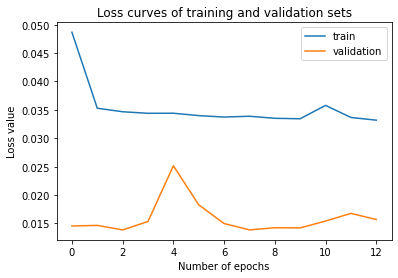

In [25]:
plt.plot(Best_GRU_history.history['loss'], label='train')
plt.plot(Best_GRU_history.history['val_loss'], label='validation')
plt.legend()
plt.title('Loss curves of training and validation sets')
plt.xlabel('Number of epochs')
plt.ylabel('Loss value')
plt.show()

Evaluating time taken for training by the best model.

In [26]:
GRU_training_time = GRU_end_time - GRU_start_time
GRU_training_time

137.30685448646545

In [27]:
y_pred_gru = Best_GRU_model.predict(X_test)

In [28]:
y_pred_gru_inv = prediction_invertor(y_pred_gru)

In [29]:
rmse_gru = metrics.mean_squared_error(y_test_inv, y_pred_gru_inv, squared=False)
print('Test RMSE: %.3f' % rmse_gru)

Test RMSE: 22.778


Evaluating the best model in terms of Mean Absolute Error.

In [30]:
mae_br = metrics.mean_absolute_error(y_test_inv, y_pred_gru_inv)
print('Test MAE: %.3f' % mae_br)

Test MAE: 14.557


Evaluating the best model in terms of R2 (R square) score.

In [31]:
r2_br = metrics.r2_score(y_test_inv, y_pred_gru_inv)
print('Test R2: %.3f' % r2_br)

Test R2: 0.940


Creating metric object of permetric library that would produce different evaluation metrics.

In [32]:
evaluator0 = RegressionMetric(y_test_inv, y_pred_gru_inv, decimal=3)

Evaluating the best model in terms of Nash-Sutcliffe Efficiency Coefficient.

In [33]:
print('Test NSE: %.3f' % evaluator0.NSE())

Test NSE: 0.940


Evaluating the best model in terms of Coefficient of Determination.

In [34]:
print('Test CC: %.3f' % evaluator0.coefficient_of_determination())

Test CC: 0.940


*Coding reference for above executions:*

https://scikit-learn.org/stable/modules/model_evaluation.html

https://pypi.org/project/permetrics/

Saving best model in the TensorFlow SavedModel format that saves model architecture, weights, optimizer and losses of the trained best model, to enable transfer learning.

In [35]:
# tf.keras.models.save_model(Best_GRU_model, os.path.join(DATA_PATH,'Saved_Models/GRU'))

*Coding reference for above executions:*

https://www.tensorflow.org/guide/keras/save_and_serialize

Creating list of other cities in the study, the data of which will be used to train and test the best model, with transfer learning as well as without transfer learning.

In [14]:
other_cities_list = ['Bengaluru', 'Hyderabad', 'Jaipur', 'Mumbai']

Load data preprocessed data set of air pollution and meteorological data for other cities into a pandas dataframes.

In [23]:
for city in other_cities_list:
  globals()[f"{city}_air_met_df"] = pd.read_csv(os.path.join(DATA_PATH,'{}_air_met_df.csv'.format(city)))

Randomly checking if the datarames are created.

In [24]:
Hyderabad_air_met_df.head()

,Unnamed: 0,Datetime,sunHour,uvIndex.1,DewPointC,HeatIndexC,cloudcover,humidity,precipMM,pressure,...,windspeedKmph,CO,NH3,NO,NO2,NOx,O3,PM10,PM2.5,SO2
0,0,2015-01-04 14:00:00,8.7,7,15,27,40,48,0.0,1013,...,13,0.24,39.02,6.10,6.34,12.44,38.17,178.41,114.18,2.96
1,1,2015-01-04 15:00:00,8.7,7,15,26,45,50,0.0,1013,...,14,0.19,36.95,2.97,5.99,8.96,38.36,191.44,122.52,1.88
2,2,2015-01-04 16:00:00,8.7,6,15,26,43,53,0.0,1013,...,14,0.17,31.50,3.26,6.27,9.53,37.33,193.73,123.99,1.90
3,3,2015-01-04 17:00:00,8.7,6,15,25,41,57,0.0,1014,...,13,0.17,44.71,3.13,6.81,9.94,38.07,191.90,122.82,1.84
4,4,2015-01-04 18:00:00,8.7,6,15,25,38,60,0.0,1015,...,13,0.25,315.00,3.14,12.47,15.61,37.38,212.79,136.19,1.61


Loading best model in the TensorFlow SavedModel format that saves model architecture, weights, optimizer and losses of the trained best model, to enable transfer learning.

In [17]:
Best_GRU_model_saved = tf.keras.models.load_model(os.path.join(DATA_PATH,'Saved_Models/LSTM'))

*Coding reference for above executions:*

https://www.tensorflow.org/guide/keras/save_and_serialize

Defining a function that woudl do all the time series data preparation, training (excluding hyperparmeter tuning), testing and evaluation of best model for other cities, all in one go.

In [18]:
def model_run(df, time_lags, saved_model, city_name):
  print('The Best model is now being checked for {} city...'.format(city_name))
  df.drop(columns=['Unnamed: 0', 'Datetime'], inplace=True)

  tr_size = int(len(df) * 0.8)
  te_size = len(df) - tr_size
  tr_df, te_df = df.iloc[0:tr_size], df.iloc[tr_size:len(df)]

  scaler_func = MinMaxScaler(feature_range=(0,1))
  tr_df = pd.DataFrame(scaler_func.fit_transform(tr_df), columns=tr_df.columns)
  te_df = pd.DataFrame(scaler_func.transform(te_df), columns=te_df.columns)

  X_tr, y_tr = create_dataset(tr_df, tr_df['PM2.5'], time_lags)
  X_te, y_te = create_dataset(te_df, te_df['PM2.5'], time_lags)

  start_time = time.time()
  history = saved_model.fit(X_tr, y_tr, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])
  end_time = time.time()

  training_time = end_time - start_time
  print('Time taken for training the model is {} seconds.'.format(training_time))

  y_predicted = saved_model.predict(X_te)
  y_predicted_inverse = np.concatenate((te_df.values[:-24,:-1], y_predicted), axis=1)
  y_predicted_inverse = scaler_func.inverse_transform(y_predicted_inverse)[:,-1]

  y_te_reshaped = y_te.reshape(-1,1)
  y_te_inverse = np.concatenate((te_df.values[:-24,:-1], y_te_reshaped), axis=1)
  y_te_inverse = scaler_func.inverse_transform(y_te_inverse)[:,-1]

  print('The evaluation metrics for {} city are as follows:'.format(city_name))
  rmse_func = metrics.mean_squared_error(y_te_inverse, y_predicted_inverse, squared=False)
  print('Test RMSE: %.3f' % rmse_func)

  mae_func = metrics.mean_absolute_error(y_te_inverse, y_predicted_inverse)
  print('Test MAE: %.3f' % mae_func)

  r2_func = metrics.r2_score(y_te_inverse, y_predicted_inverse)
  print('Test R2: %.3f' % r2_func)

  evaluator_func = RegressionMetric(y_te_inverse, y_predicted_inverse, decimal=3)
  print('Test NSE: %.3f' % evaluator_func.NSE())
  print('Test CC: %.3f' % evaluator_func.coefficient_of_determination())

  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='validation')
  plt.legend()
  plt.title('Loss curves of training and validation sets')
  plt.xlabel('Number of epochs')
  plt.ylabel('Loss value')
  plt.show()

Training, testing and evaluation of saved best model with transfer learning for different city.

The Best model is now being checked for Bengaluru city...
Epoch 1/100
479/479 [==============================] - 13s 22ms/step - loss: 0.0342 - val_loss: 0.0167
Epoch 2/100
479/479 [==============================] - 10s 22ms/step - loss: 0.0318 - val_loss: 0.0199
Epoch 3/100
479/479 [==============================] - 11s 24ms/step - loss: 0.0313 - val_loss: 0.0161
Epoch 4/100
479/479 [==============================] - 12s 25ms/step - loss: 0.0311 - val_loss: 0.0174
Epoch 5/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0310 - val_loss: 0.0167
Epoch 6/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0310 - val_loss: 0.0167
Epoch 7/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0308 - val_loss: 0.0157
Epoch 8/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0308 - val_loss: 0.0154
Epoch 9/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0309 - val_loss: 0.0156
Epoch 10/100
47

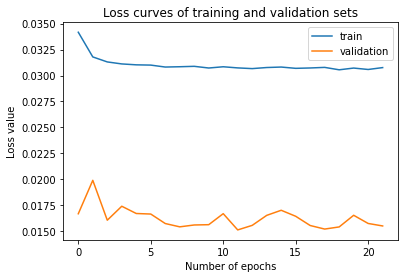

In [19]:
model_run(Bengaluru_air_met_df,24,Best_GRU_model_saved,'Bengaluru')

Training, testing and evaluation of best model without transfer learning for same city as above.

**NOTE:** Before executing the below two lines, the code that loads dataframes for other cities has to be rerun to avoid any errors.

In [26]:
BLR_GRU_model = keras.Sequential()
BLR_GRU_model.add(layers.GRU(80, input_shape=(24, 21)))
BLR_GRU_model.add(layers.Dropout(0.5))
BLR_GRU_model.add(layers.Dense(1))
BLR_GRU_model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=tfa.optimizers.AdamW(weight_decay=0.00001, learning_rate=0.01))

The Best model is now being checked for Bengaluru city...
Epoch 1/100
479/479 [==============================] - 13s 22ms/step - loss: 0.0467 - val_loss: 0.0201
Epoch 2/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0334 - val_loss: 0.0158
Epoch 3/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0331 - val_loss: 0.0166
Epoch 4/100
479/479 [==============================] - 12s 25ms/step - loss: 0.0327 - val_loss: 0.0185
Epoch 5/100
479/479 [==============================] - 11s 23ms/step - loss: 0.0326 - val_loss: 0.0205
Epoch 6/100
479/479 [==============================] - 12s 24ms/step - loss: 0.0324 - val_loss: 0.0230
Epoch 7/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0321 - val_loss: 0.0157
Epoch 8/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0324 - val_loss: 0.0162
Epoch 9/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0319 - val_loss: 0.0169
Epoch 10/100
47

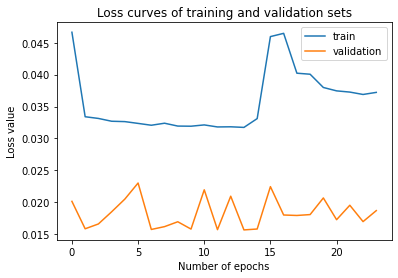

In [27]:
model_run(Bengaluru_air_met_df,24,BLR_GRU_model,'Bengaluru')

Training, testing and evaluation of saved best model with transfer learning for different city.

The Best model is now being checked for Hyderabad city...
Epoch 1/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0261 - val_loss: 0.0067
Epoch 2/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0256 - val_loss: 0.0067
Epoch 3/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0255 - val_loss: 0.0098
Epoch 4/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0255 - val_loss: 0.0066
Epoch 5/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0255 - val_loss: 0.0070
Epoch 6/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0254 - val_loss: 0.0066
Epoch 7/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0255 - val_loss: 0.0071
Epoch 8/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0254 - val_loss: 0.0070
Epoch 9/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0255 - val_loss: 0.0086
Epoch 10/100
47

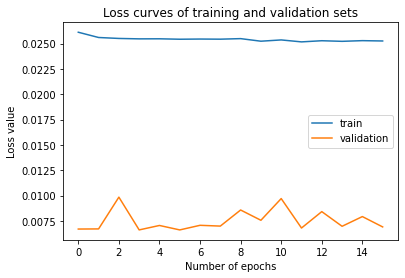

In [20]:
model_run(Hyderabad_air_met_df,24,Best_GRU_model_saved,'Hyderabad')

Training, testing and evaluation of best model without transfer learning for same city as above.

**NOTE:** Before executing the below two lines, the code that loads dataframes for other cities has to be rerun to avoid any errors.

In [28]:
HYD_GRU_model = keras.Sequential()
HYD_GRU_model.add(layers.GRU(80, input_shape=(24, 21)))
HYD_GRU_model.add(layers.Dropout(0.5))
HYD_GRU_model.add(layers.Dense(1))
HYD_GRU_model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=tfa.optimizers.AdamW(weight_decay=0.00001, learning_rate=0.01))

The Best model is now being checked for Hyderabad city...
Epoch 1/100
479/479 [==============================] - 13s 22ms/step - loss: 0.0392 - val_loss: 0.0096
Epoch 2/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0286 - val_loss: 0.0089
Epoch 3/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0285 - val_loss: 0.0104
Epoch 4/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0279 - val_loss: 0.0131
Epoch 5/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0279 - val_loss: 0.0103
Epoch 6/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0276 - val_loss: 0.0110
Epoch 7/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0274 - val_loss: 0.0081
Epoch 8/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0270 - val_loss: 0.0072
Epoch 9/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0271 - val_loss: 0.0089
Epoch 10/100
47

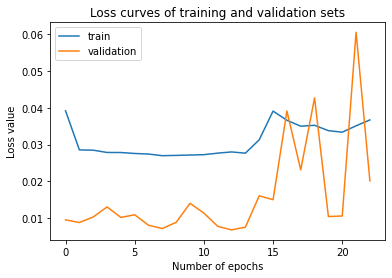

In [29]:
model_run(Hyderabad_air_met_df,24,HYD_GRU_model,'Hyderabad')

Training, testing and evaluation of saved best model with transfer learning for different city.

The Best model is now being checked for Jaipur city...
Epoch 1/100
244/244 [==============================] - 5s 22ms/step - loss: 0.0196 - val_loss: 0.0101
Epoch 2/100
244/244 [==============================] - 5s 22ms/step - loss: 0.0188 - val_loss: 0.0096
Epoch 3/100
244/244 [==============================] - 5s 22ms/step - loss: 0.0186 - val_loss: 0.0108
Epoch 4/100
244/244 [==============================] - 5s 21ms/step - loss: 0.0185 - val_loss: 0.0094
Epoch 5/100
244/244 [==============================] - 5s 22ms/step - loss: 0.0183 - val_loss: 0.0093
Epoch 6/100
244/244 [==============================] - 5s 22ms/step - loss: 0.0182 - val_loss: 0.0093
Epoch 7/100
244/244 [==============================] - 5s 22ms/step - loss: 0.0182 - val_loss: 0.0092
Epoch 8/100
244/244 [==============================] - 5s 21ms/step - loss: 0.0182 - val_loss: 0.0093
Epoch 9/100
244/244 [==============================] - 5s 22ms/step - loss: 0.0181 - val_loss: 0.0094
Epoch 10/100
244/244 [=====

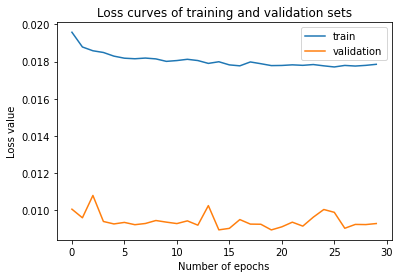

In [21]:
model_run(Jaipur_air_met_df,24,Best_GRU_model_saved,'Jaipur')

Training, testing and evaluation of best model without transfer learning for same city as above.

**NOTE:** Before executing the below two lines, the code that loads dataframes for other cities has to be rerun to avoid any errors.

In [30]:
JPR_GRU_model = keras.Sequential()
JPR_GRU_model.add(layers.GRU(80, input_shape=(24, 21)))
JPR_GRU_model.add(layers.Dropout(0.5))
JPR_GRU_model.add(layers.Dense(1))
JPR_GRU_model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=tfa.optimizers.AdamW(weight_decay=0.00001, learning_rate=0.01))

The Best model is now being checked for Jaipur city...
Epoch 1/100
244/244 [==============================] - 8s 24ms/step - loss: 0.0459 - val_loss: 0.0196
Epoch 2/100
244/244 [==============================] - 5s 21ms/step - loss: 0.0228 - val_loss: 0.0102
Epoch 3/100
244/244 [==============================] - 5s 21ms/step - loss: 0.0220 - val_loss: 0.0134
Epoch 4/100
244/244 [==============================] - 5s 21ms/step - loss: 0.0217 - val_loss: 0.0117
Epoch 5/100
244/244 [==============================] - 5s 21ms/step - loss: 0.0211 - val_loss: 0.0112
Epoch 6/100
244/244 [==============================] - 5s 21ms/step - loss: 0.0216 - val_loss: 0.0136
Epoch 7/100
244/244 [==============================] - 5s 21ms/step - loss: 0.0208 - val_loss: 0.0132
Epoch 8/100
244/244 [==============================] - 5s 21ms/step - loss: 0.0210 - val_loss: 0.0226
Epoch 9/100
244/244 [==============================] - 5s 22ms/step - loss: 0.0210 - val_loss: 0.0114
Epoch 10/100
244/244 [=====

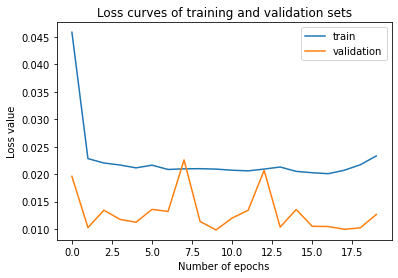

In [31]:
model_run(Jaipur_air_met_df,24,JPR_GRU_model,'Jaipur')

Training, testing and evaluation of saved best model with transfer learning for different city.

The Best model is now being checked for Mumbai city...
Epoch 1/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0507 - val_loss: 0.0194
Epoch 2/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0502 - val_loss: 0.0168
Epoch 3/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0503 - val_loss: 0.0179
Epoch 4/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0501 - val_loss: 0.0149
Epoch 5/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0502 - val_loss: 0.0150
Epoch 6/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0500 - val_loss: 0.0160
Epoch 7/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0502 - val_loss: 0.0158
Epoch 8/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0501 - val_loss: 0.0153
Epoch 9/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0500 - val_loss: 0.0152
Epoch 10/100
479/4

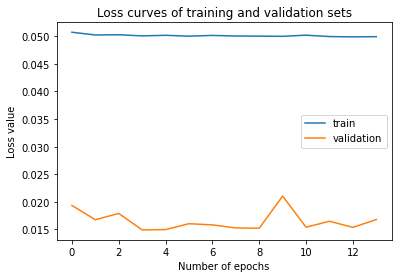

In [22]:
model_run(Mumbai_air_met_df,24,Best_GRU_model_saved,'Mumbai')

Training, testing and evaluation of best model without transfer learning for same city as above.

**NOTE:** Before executing the below two lines, the code that loads dataframes for other cities has to be rerun to avoid any errors.

In [32]:
BOM_GRU_model = keras.Sequential()
BOM_GRU_model.add(layers.GRU(80, input_shape=(24, 21)))
BOM_GRU_model.add(layers.Dropout(0.5))
BOM_GRU_model.add(layers.Dense(1))
BOM_GRU_model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=tfa.optimizers.AdamW(weight_decay=0.00001, learning_rate=0.01))

The Best model is now being checked for Mumbai city...
Epoch 1/100
479/479 [==============================] - 13s 22ms/step - loss: 0.0660 - val_loss: 0.0381
Epoch 2/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0528 - val_loss: 0.0166
Epoch 3/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0524 - val_loss: 0.0254
Epoch 4/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0525 - val_loss: 0.0171
Epoch 5/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0521 - val_loss: 0.0177
Epoch 6/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0517 - val_loss: 0.0189
Epoch 7/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0515 - val_loss: 0.0183
Epoch 8/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0517 - val_loss: 0.0198
Epoch 9/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0513 - val_loss: 0.0163
Epoch 10/100
479/4

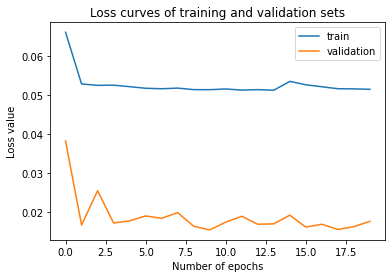

In [33]:
model_run(Mumbai_air_met_df,24,BOM_GRU_model,'Mumbai')